# Spatial Stations - Extreme Statistics

In [1]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray
from scipy.stats import rv_histogram, genextreme
from bayesevt._src.geoprocessing.math import safe_reciprocal
from bayesevt._src.models.density import DeterministicGEVD
from geo_toolz._src.masks.country import add_country_mask
from geo_toolz._src.masks.land import add_land_mask
from geo_toolz._src.masks.ocean import add_ocean_mask
from geo_toolz._src.validation.coords import validate_longitude, validate_latitude
from geo_toolz._src.encoders.time import time_rescale, time_unrescale
from geo_toolz._src.discretize.grid import RegularLonLat
from geo_toolz._src.data.reanalysis.gee import download_era5_gee
from geo_toolz.extremes import calculate_block_maxima_ts, calculate_pot_quantile, calculate_pot_ts, calculate_pp_counts_ts, calculate_pp_stats_ts
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.crs import CRS
import arviz as az
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)




%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [2]:
data_url = "/pool/usuarios/juanjohn/data/bayesevt/clean/observations/stations_spain.nc"
figures_save_dir = Path(f"/pool/usuarios/juanjohn/projects/bayesevt/figures/tutorial/spain/eda/maps")
full_save_name = "bm"
figures_save_dir.mkdir(parents=True, exist_ok=True)

In [3]:
ds = xr.open_mfdataset(data_url).load()
ds = add_country_mask(ds, "Spain") 
ds = ds.where(ds.spain_mask==1, drop=True)#.t2m_max
ds

<xarray.Dataset> Size: 25MB
Dimensions:       (station_id: 137, time: 22645)
Coordinates:
    lon           (station_id) float32 548B 1.108 1.217 2.102 ... 0.8755 0.6883
    lat           (station_id) float32 548B 41.15 41.19 41.52 ... 42.7 42.77
    alt           (station_id) float32 548B 118.0 71.0 146.0 ... 1.161e+03 722.0
    station_name  (station_id) <U40 22kB 'reus (centre lectura)' ... 'bossòst...
  * station_id    (station_id) <U5 3kB '0016B' '0040F' ... '9990X' '9994X'
  * time          (time) datetime64[ns] 181kB 1961-01-01 ... 2022-12-31
    spain_mask    (station_id) int16 274B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Data variables:
    t2m_max       (station_id, time) float64 25MB 10.28 14.48 ... 18.8 24.2

## Block Maxima Extremes

In [4]:
from geo_toolz._src.subset.where import where_slice

In [5]:
# block maximum
ds_bm = ds.resample(time="1YE").max().sel(time=slice(None, "2022"))
# ds_bm = ds_bm.where(ds_bm.t2m_max > 35, drop=True).dropna(dim="station_id")

#### Mean

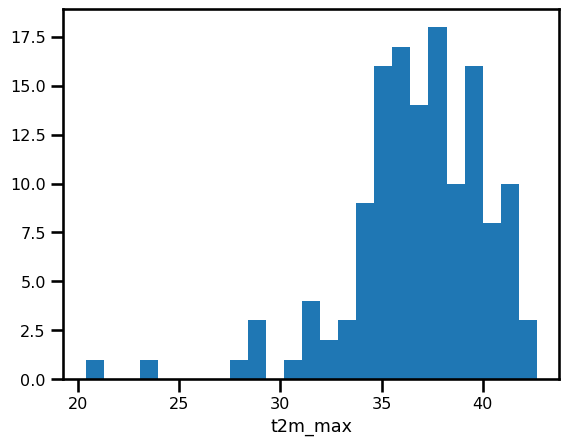

In [6]:
ds_bm.mean(dim=["time"]).t2m_max.plot.hist(bins=25);
# ds_bm.std(dim=["time"]).t2m_max.plot.hist(bins=25);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


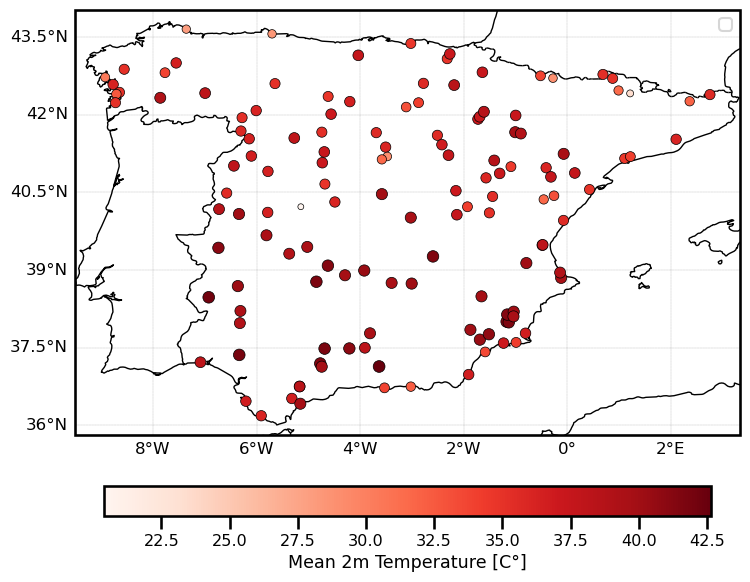

In [7]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Mean 2m Temperature [C°]"
}

ds_bm.mean(dim=["time"]).plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="Reds", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
# fig.suptitle(f"T2Max - Mean")
plt.legend()
plt.tight_layout()
fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_mean.png")) 
plt.show()



#### Standard Deviation

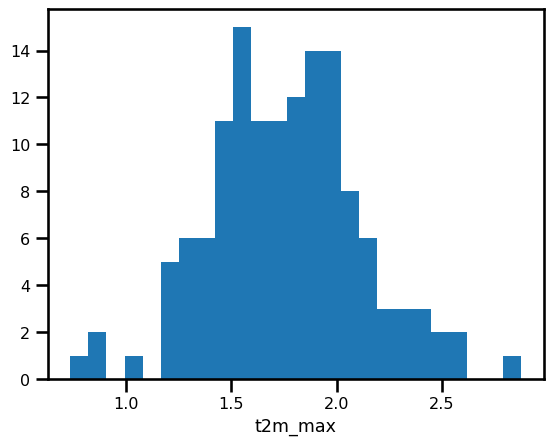

In [8]:
ds_bm.std(dim=["time"]).t2m_max.plot.hist(bins=25);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


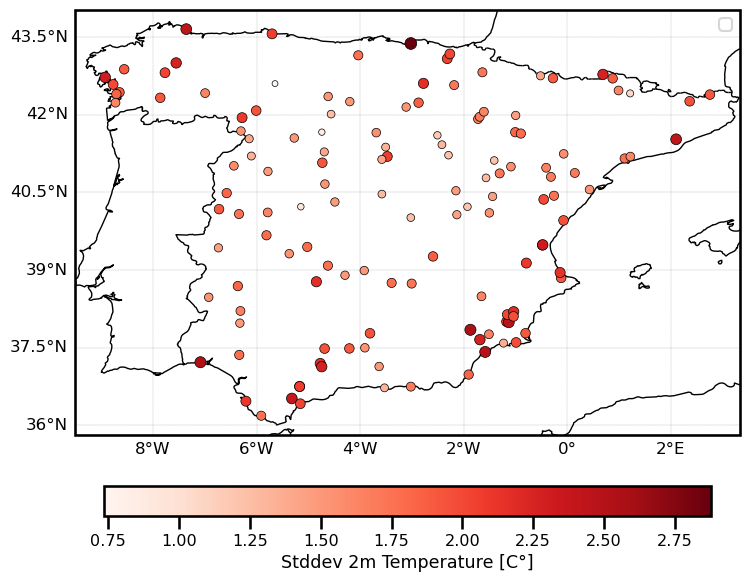

In [9]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Stddev 2m Temperature [C°]"
}

ds_bm.std(dim=["time"]).plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="Reds", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
plt.legend()
plt.tight_layout()

fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_std.png")) 
plt.show()


#### Kurtosis

In [10]:
from scipy.stats import kurtosis

def fn(x):
    x = kurtosis(x)
    return np.atleast_1d(x)

out = xr.apply_ufunc(
    fn,
    ds_bm.t2m_max,
    input_core_dims=[["time"]],
    vectorize=True
).to_dataset()


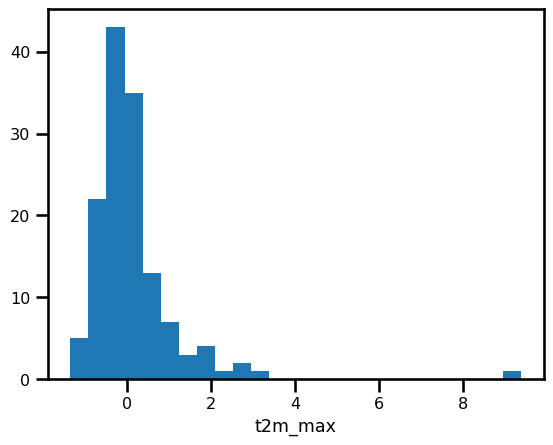

In [11]:
out.t2m_max.plot.hist(bins=25);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


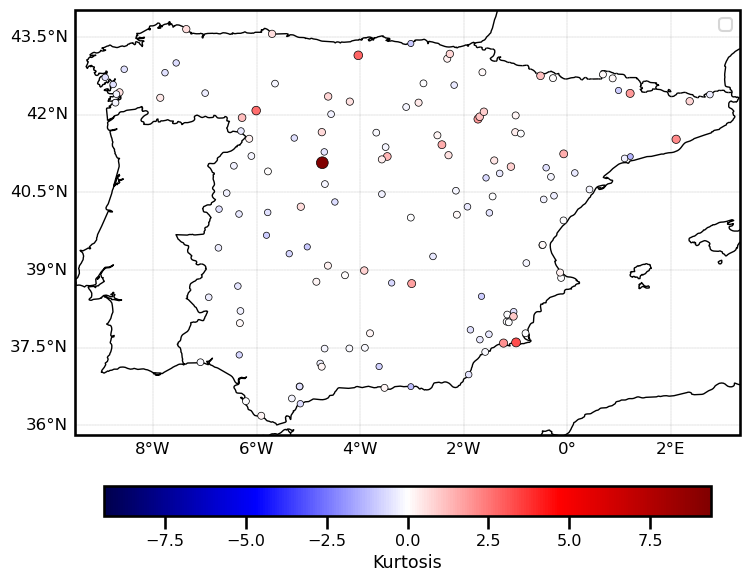

In [12]:

fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Kurtosis"
}

out.plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="seismic", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
plt.legend()
plt.tight_layout()
fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_kurtosis.png")) 
plt.show()

#### Skew

In [13]:
from scipy.stats import kurtosis, skew

def fn(x):
    x = skew(x)
    return np.atleast_1d(x)

out = xr.apply_ufunc(
    fn,
    ds_bm.t2m_max,
    input_core_dims=[["time"]],
    vectorize=True
).to_dataset()

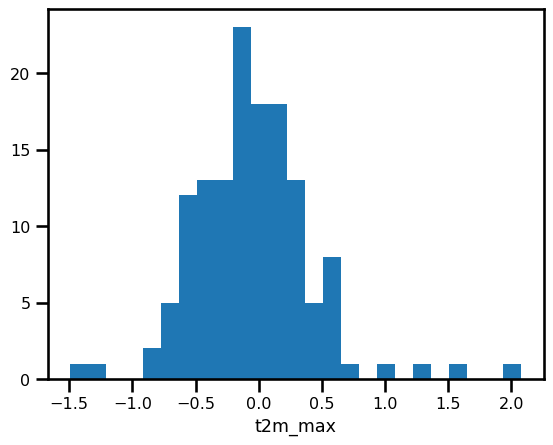

In [14]:
out.t2m_max.plot.hist(bins=25);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


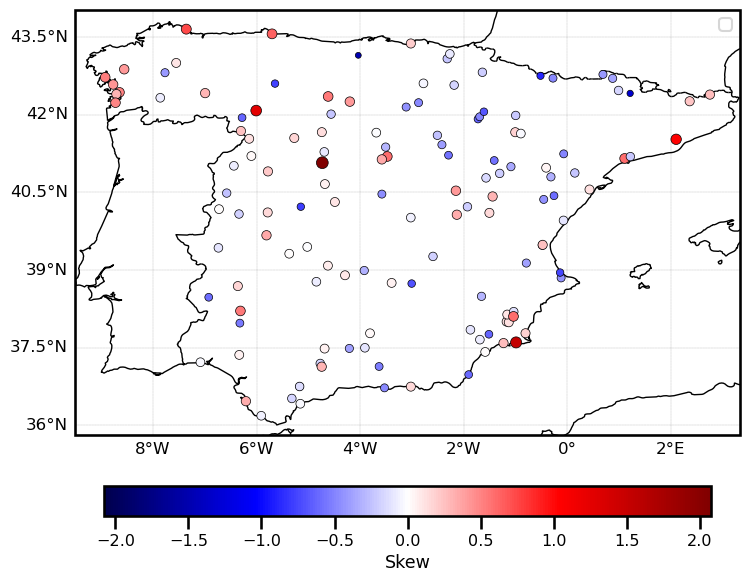

In [15]:


fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Skew"
}

out.plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="seismic", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
plt.legend()
plt.tight_layout()
fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_skew.png")) 
plt.show()

## Peak-Over-Threshold


In [16]:
# intensity threshold
quantile = 0.95
threshold_init = np.floor(calculate_pot_quantile(ds.t2m_max, quantile=quantile)).T
# print(f"Threshold: {threshold_init.item():.2f}")
ds_pot = ds.where(ds.t2m_max >= threshold_init, drop=False).sel(time=slice(None, "2022")).squeeze()


# temporal discretization
num_days = 3
freq = "D"
dt = f"{num_days}{freq}"
# dt = "3D" # 3 Days # 1 Month
print(f"Temporal Discretization: {dt}")
ds_pot = ds_pot.resample(time=dt).max().fillna(np.nan)
ds_pot["mask"] = np.isfinite(ds_pot.t2m_max)

Temporal Discretization: 3D


In [17]:
ds_pot["threshold"] = (("station_id"), threshold_init.squeeze())
ds_pot

<xarray.Dataset> Size: 9MB
Dimensions:       (time: 7549, station_id: 137)
Coordinates:
    lon           (station_id) float32 548B 1.108 1.217 2.102 ... 0.8755 0.6883
    lat           (station_id) float32 548B 41.15 41.19 41.52 ... 42.7 42.77
    alt           (station_id) float32 548B 118.0 71.0 146.0 ... 1.161e+03 722.0
    station_name  (station_id) <U40 22kB 'reus (centre lectura)' ... 'bossòst...
  * station_id    (station_id) <U5 3kB '0016B' '0040F' ... '9990X' '9994X'
    spain_mask    (station_id) int16 274B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * time          (time) datetime64[ns] 60kB 1961-01-01 ... 2022-12-31
Data variables:
    t2m_max       (time, station_id) float64 8MB nan nan nan nan ... nan nan nan
    mask          (time, station_id) bool 1MB False False False ... False False
    threshold     (station_id) float64 1kB 30.0 30.0 31.0 ... 33.0 29.0 28.0

In [18]:
quantile_name = int(str(quantile).split(".")[-1])
full_save_name = f"pot_q{quantile_name}_dc{dt}"
full_save_name

'pot_q95_dc3D'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


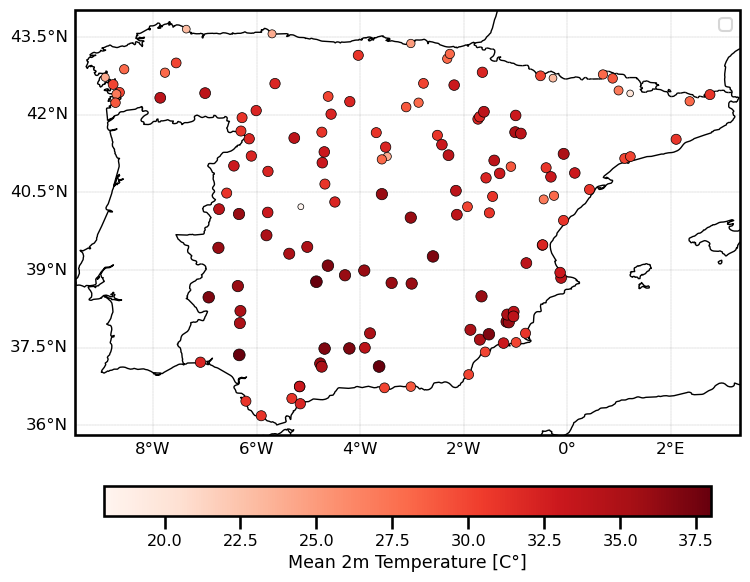

In [19]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Mean 2m Temperature [C°]"
}

ds_pot.mean(dim=["time"]).plot.scatter(
    x="lon", y="lat", hue="threshold", 
    markersize="threshold",
    ax=ax, cmap="Reds", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
# fig.suptitle(f"T2Max - Mean")
plt.legend()
plt.tight_layout()
fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_threshold.png")) 
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


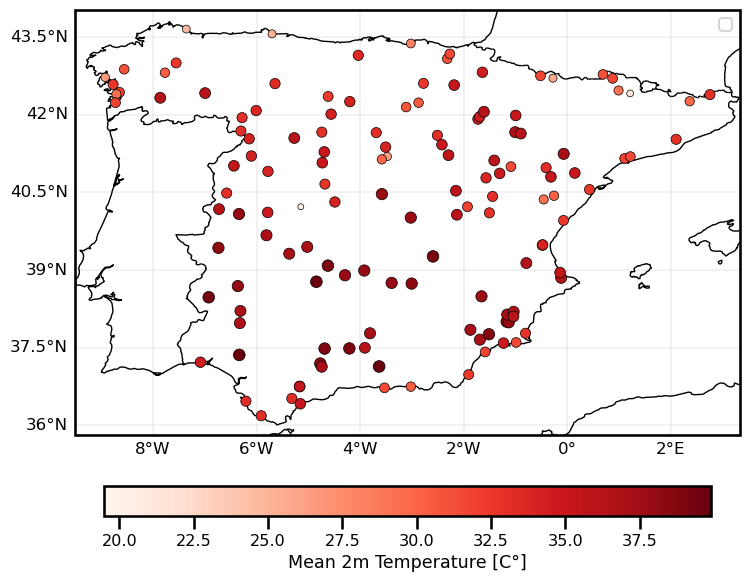

In [20]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Mean 2m Temperature [C°]"
}

ds_pot.mean(dim=["time"]).plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="Reds", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
# fig.suptitle(f"T2Max - Mean")
plt.legend()
plt.tight_layout()
fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_mean.png")) 
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


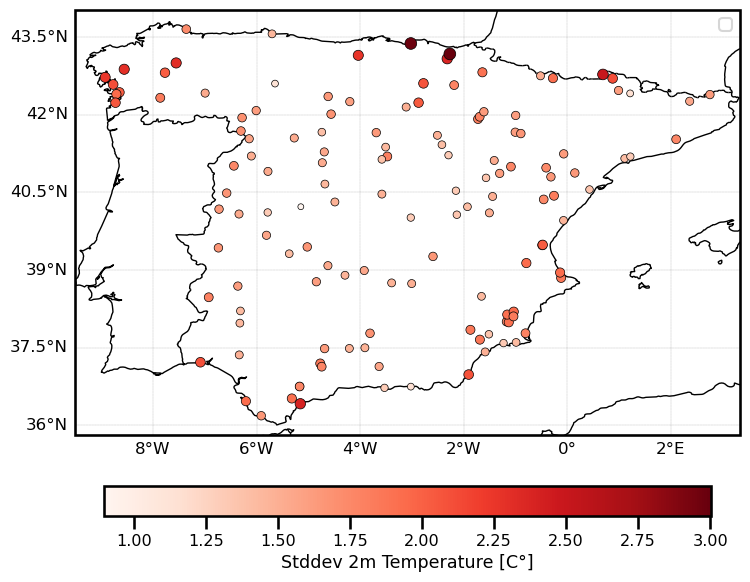

In [21]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Stddev 2m Temperature [C°]"
}

ds_pot.std(dim=["time"]).plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="Reds", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
plt.legend()
plt.tight_layout()

fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_std.png")) 
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


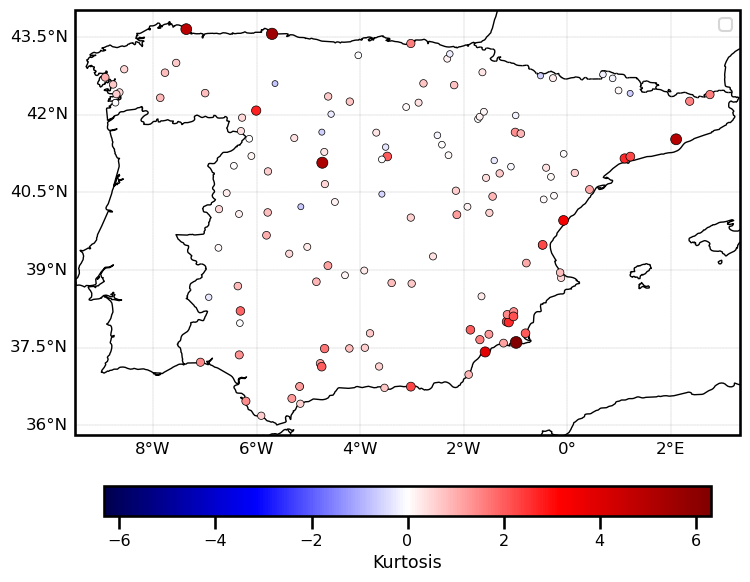

In [22]:
from scipy.stats import kurtosis

def fn(x):
    idx = np.isfinite(x)
    x = kurtosis(x[idx])
    return np.atleast_1d(x)

out = xr.apply_ufunc(
    fn,
    ds_pot.t2m_max,
    input_core_dims=[["time"]],
    vectorize=True
).to_dataset()

fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Kurtosis"
}

out.plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="seismic", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
plt.legend()
plt.tight_layout()
fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_kurtosis.png")) 
plt.show()

#### Skew

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


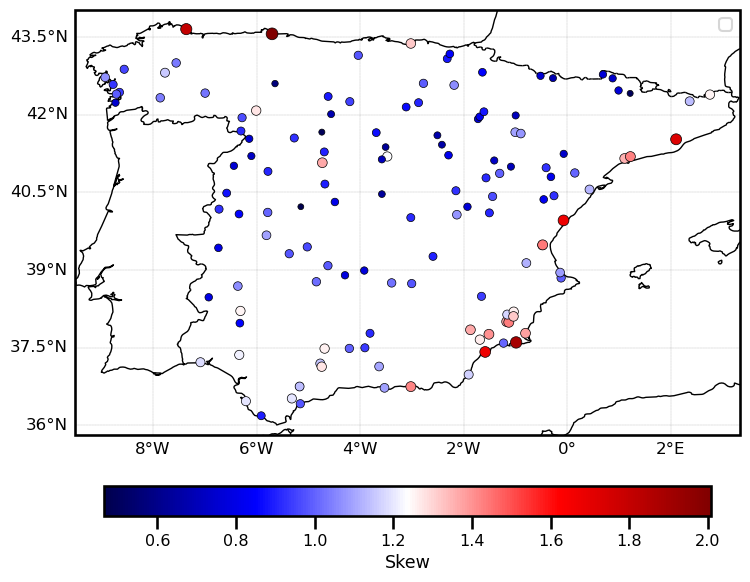

In [23]:
from scipy.stats import kurtosis, skew

def fn(x):
    idx = np.isfinite(x)
    x = skew(x[idx])
    return np.atleast_1d(x)

out = xr.apply_ufunc(
    fn,
    ds_pot.t2m_max,
    input_core_dims=[["time"]],
    vectorize=True
).to_dataset()

fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Skew"
}

out.plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="seismic", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
plt.legend()
plt.tight_layout()
fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_skew.png")) 
plt.show()

### Point Process

In [24]:
# Peak Over Threshold
quantile = 0.98
decluster_freq = 3
threshold = calculate_pot_quantile(ds.t2m_max, quantile=quantile).squeeze()[:, None]
ds_pp = ds.where(ds >= threshold)
# Point Process
ds_pp = ds_pp.resample(time="1YE").count().fillna(0.0).sel(time=slice(None, "2022"))
# ds_pot = calculate_pot_ts(ds.t2m_max, quantile=quantile, decluster_freq=decluster_freq).sel(time=slice(None, "2022"))

quantile_name = int(str(quantile).split(".")[-1])
full_save_name = f"pp_q{quantile_name}_dc{decluster_freq}"

In [25]:
ds_pp.max()

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    t2m_max  float64 8B 93.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


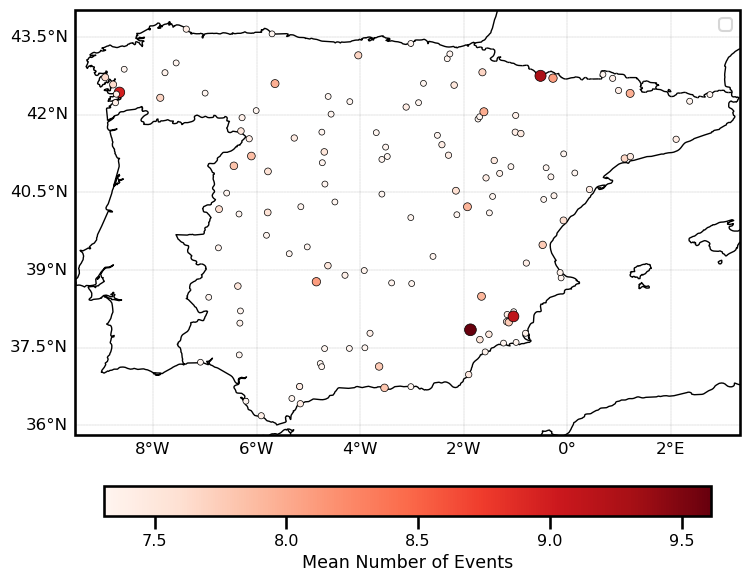

In [26]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Mean Number of Events"
}

ds_pp.mean(dim=["time"]).plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="Reds", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
# fig.suptitle(f"T2Max - Mean")
plt.legend()
plt.tight_layout()
fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_mean.png")) 
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


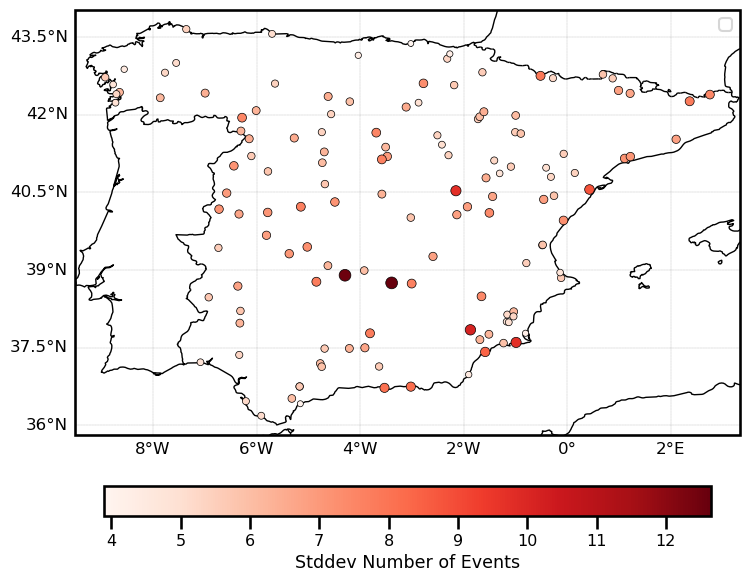

In [27]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Stddev Number of Events"
}

ds_pp.std(dim=["time"]).plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="Reds", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
plt.legend()
plt.tight_layout()

fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_std.png")) 
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


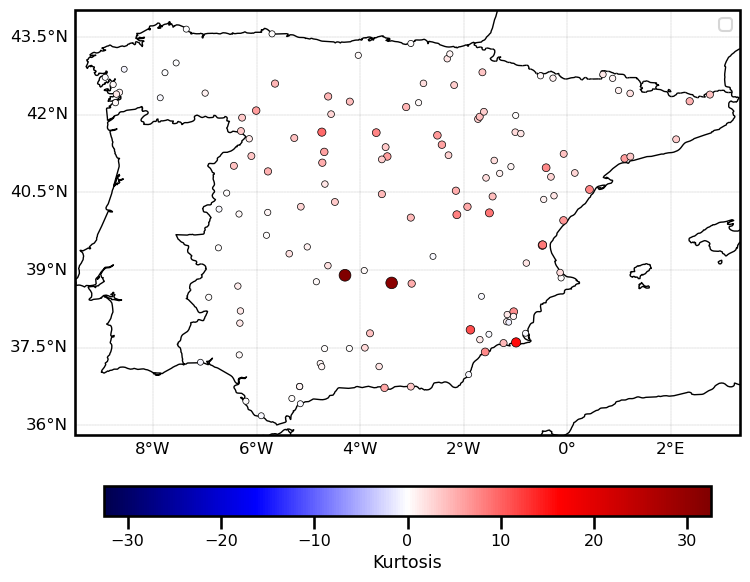

In [28]:
from scipy.stats import kurtosis

def fn(x):
    idx = np.isfinite(x)
    x = kurtosis(x[idx])
    return np.atleast_1d(x)

out = xr.apply_ufunc(
    fn,
    ds_pp.t2m_max,
    input_core_dims=[["time"]],
    vectorize=True
).to_dataset()

fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Kurtosis"
}

out.plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="seismic", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
plt.legend()
plt.tight_layout()
fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_kurtosis.png")) 
plt.show()

#### Skew

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


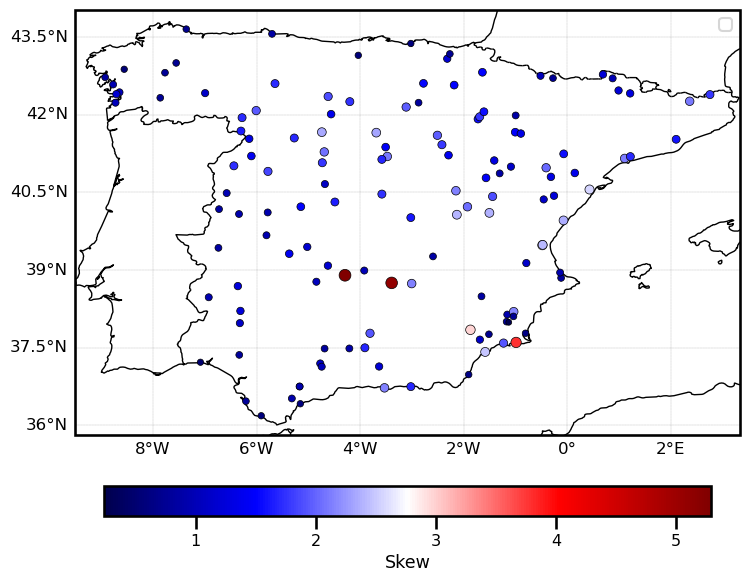

In [29]:
from scipy.stats import kurtosis, skew

def fn(x):
    idx = np.isfinite(x)
    x = skew(x[idx])
    return np.atleast_1d(x)

out = xr.apply_ufunc(
    fn,
    ds_pp.t2m_max,
    input_core_dims=[["time"]],
    vectorize=True
).to_dataset()

fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
    "label": "Skew"
}

out.plot.scatter(
    x="lon", y="lat", hue="t2m_max", 
    markersize="t2m_max",
    ax=ax, cmap="seismic", 
    # alpha=0.5,
    # vmin=0.0, 
    marker="o",
    edgecolors="black", 
    linewidths=0.5, 
    zorder=3,
    cbar_kwargs=cbar_kwargs
)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
# ax.set(title=variable)
ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
plt.legend()
plt.tight_layout()
fig.savefig(figures_save_dir.joinpath(f"{full_save_name}_t2mmax_spain_skew.png")) 
plt.show()